# Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('../data/data.csv')

***
## SECTION 1: BASIC INSPECTION OF THE DATASET

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

#### Objective here is to check:
- min, max, mean and standard deviation for anomalies
- how many unique values does columns have (to better understand them, and decide how to further analyse them)

In [4]:
print(df.shape)
df.describe(include='all')

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
count,30697,30697,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697,30697.000000,30697.000000,25697.000000,30697,30697,30697,30697,3.069700e+04,30697,30697,30697,30697,30697.000000
unique,57,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,2,6,7,5,NaN,1,1559,74,33,NaN
top,Jump Shot,Jump Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-06,NaN,NaN,NaN,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,NaN,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS,NaN
freq,18880,23485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2318,NaN,NaN,NaN,24271,13455,12625,9398,NaN,30697,50,1020,1978,NaN
mean,NaN,NaN,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,NaN,28.365085,13.437437,0.446161,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,15349.000000
std,NaN,NaN,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,NaN,17.478949,9.374189,0.497103,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,8861.604943
min,NaN,NaN,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,NaN,13.000000,5.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,7675.000000
50%,NaN,NaN,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,NaN,28.000000,15.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,15349.000000
75%,NaN,NaN,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,NaN,43.000000,21.000000,1.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,23023.000000


***
## SECTION 2: Removing Redundant Columns
There are some columns that have very high corelations with some other columns and some columns that

Removing columns:
- team_name, team_id - These have only a single value, so it doesn't add any value to the prediction
- matchup - It has 1 to 1 corelation with the column "opponent"

In [5]:
def remove_columns(df):
    columns_to_drop = ['team_name', 'team_id']
    df = df.drop(labels=columns_to_drop, axis='columns')
    print(f"Total columns removed: {len(columns_to_drop)}")
    return df

## Section 3: Dealing With Missing Values and Duplicates

In [6]:
def remove_na_rows(df: pd.DataFrame):
    """
    :param pd.DataFrame df:
    :return pd.DataFrame
    """
    num_rows_before = len(df)
    print(f'Number of rows: {num_rows_before}')
    df = df.dropna()
    num_rows_after = len(df)
    print(f'Number of rows after dropping missing values: {num_rows_after}')
    removed_rows = num_rows_before - num_rows_after
    print(f'Percentage of data removed: {100 * (removed_rows/num_rows_before)} %')
    return df

In [7]:
df = remove_na_rows(df)

Number of rows: 30697
Number of rows after dropping missing values: 25697
Percentage of data removed: 16.28823663550184 %


In [8]:
def remove_duplicates(df: pd.DataFrame):
    num_rows_before = len(df)
    print(f'Number of rows: {num_rows_before}')
    df = df.drop_duplicates()
    num_rows_after = len(df)
    print(f'Number of rows after dropping duplicates: {num_rows_after}')
    removed_rows = num_rows_before - num_rows_after
    print(f'Percentage of duplicate data removed: {100 * (removed_rows/num_rows_before)} %')
    return df

In [9]:
df = remove_duplicates(df)

Number of rows: 25697
Number of rows after dropping duplicates: 25697
Percentage of duplicate data removed: 0.0 %


***
## Section 4: Outlier detection
From our analysis of the above data (mostly looking at mean, min, max) we can see that most likely there no outliers. But still we will have a thorough look at all the columns to understand them and confirm that there is no outliers. 

#### For Column: `game_event_id` & `game_id`

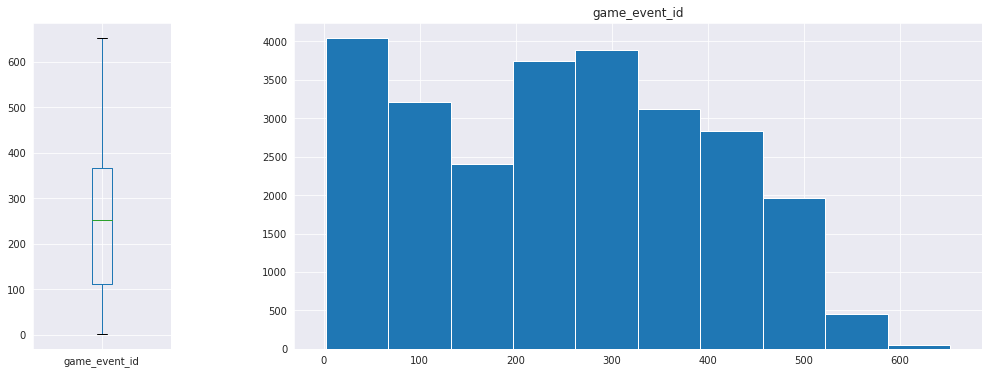

In [28]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='game_event_id',ax=axes[0]);
df.hist(column='game_event_id', ax=axes[1]);

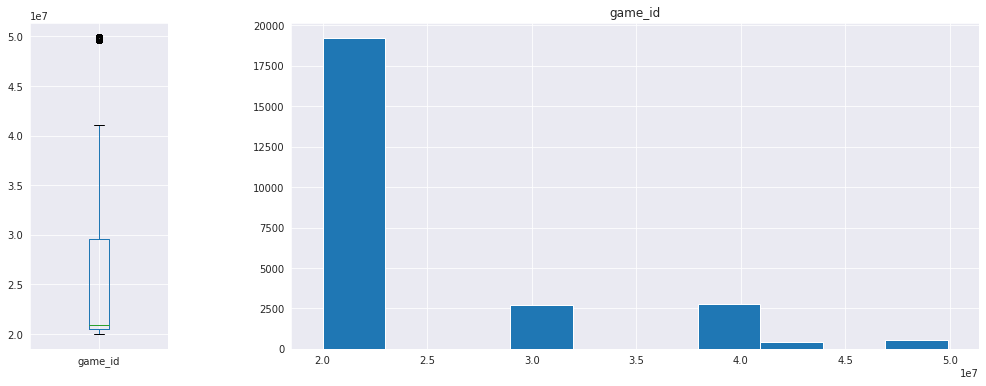

In [29]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='game_id',ax=axes[0]);
df.hist(column='game_id', ax=axes[1]);

These are not outliers, 'game_id' is unique number associated with a single match. In this case it just so happens
that in the number system some matches an ID of very high value, but from the overall structre of the above bar chart everything looks good.

#### For Column: `lat`, `lon`, `loc_x`, `loc_y`

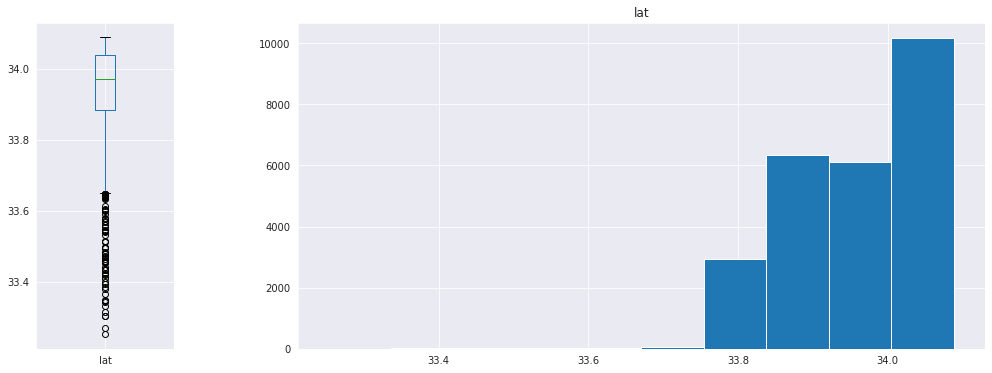

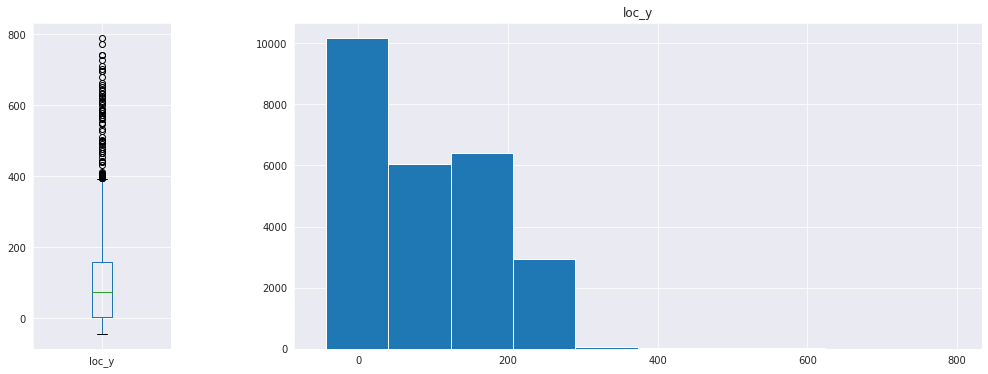

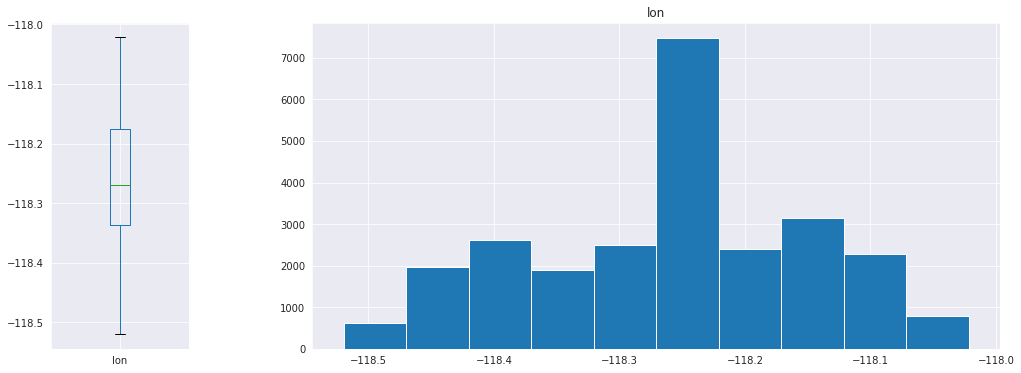

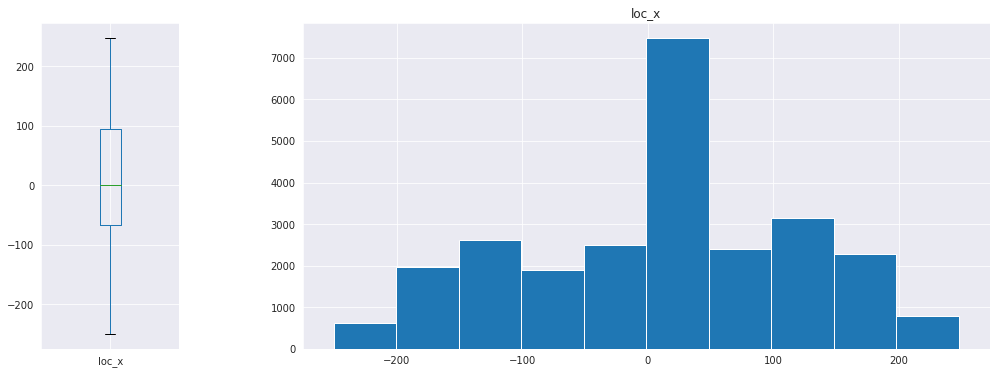

In [30]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='lat',ax=axes[0]);
df.hist(column='lat', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='loc_y',ax=axes[0]);
df.hist(column='loc_y', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='lon',ax=axes[0]);
df.hist(column='lon', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='loc_x',ax=axes[0]);
df.hist(column='loc_x', ax=axes[1]);

From this we can see that (`lat`, `lon`) and (`loc_x`, `loc_y`) present the same information just in different encoding. This allows us to drop 2 additional columns as they provide the same information.

Also It looks in `lat` and `loc_y` that there might be lot of outliers, but the below diagram tell shows us that, these points are not outliers. In this case these points should be within the court boundry, if that is the case then they are not outliers, as we can see below.

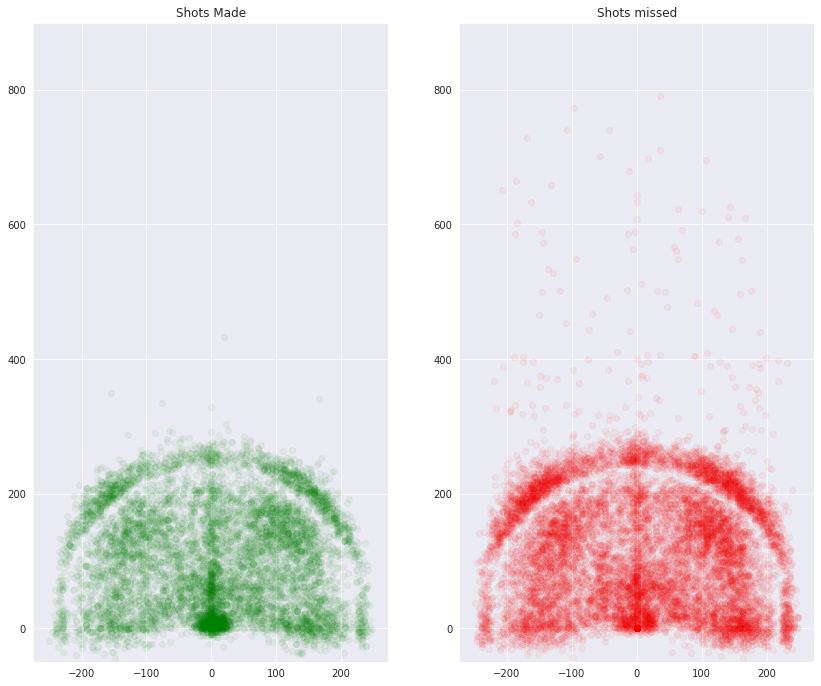

In [31]:
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# hit
plt.subplot(121)
h = df.loc[df.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha=alpha)
plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
h = df.loc[df.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=alpha)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])
plt.savefig('shots_made_and_missed.png')

Since (`lat`, `lon`) and (`loc_x`, `loc_y`) present the same information we can drop a pair. 
We have decided to drop the columns: `lat`, `lon` in this case.

#### For Column: `shot_distance`

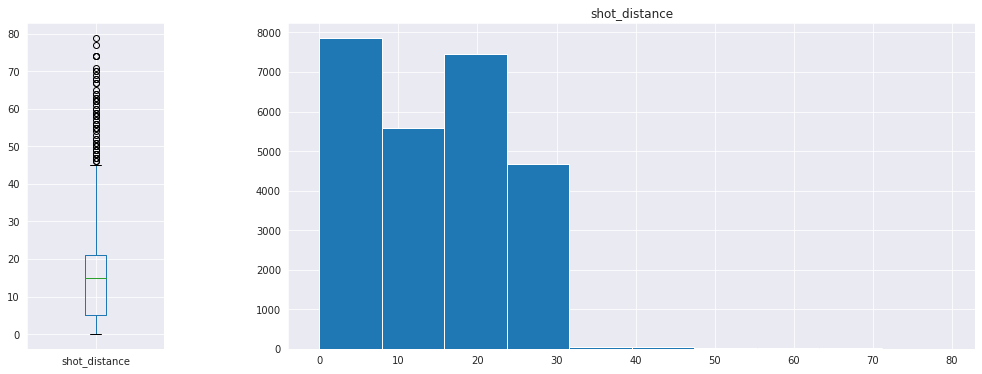

In [32]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='shot_distance',ax=axes[0]);
df.hist(column='shot_distance', ax=axes[1]);

As we saw with `lat` and `loc_y`, there are few shots that were made far away from the hoop. So these are not outliers but rather the minority shots. 

We might need to normalize this column.

#### For Column: `minutes_remaining` & `seconds_remaining`

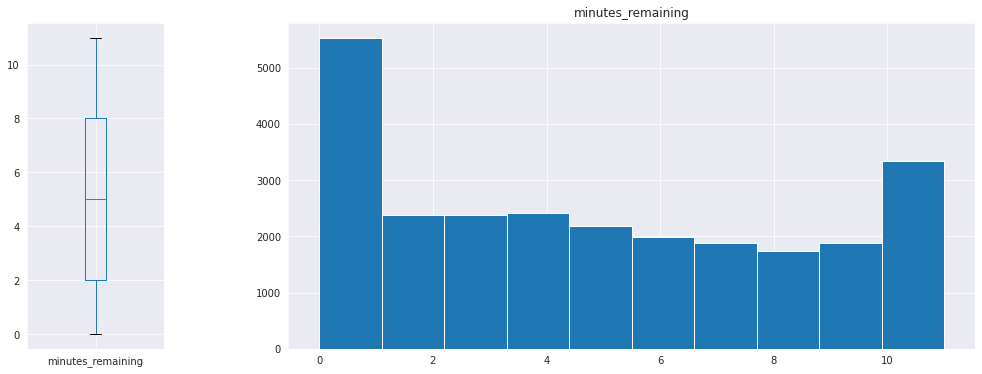

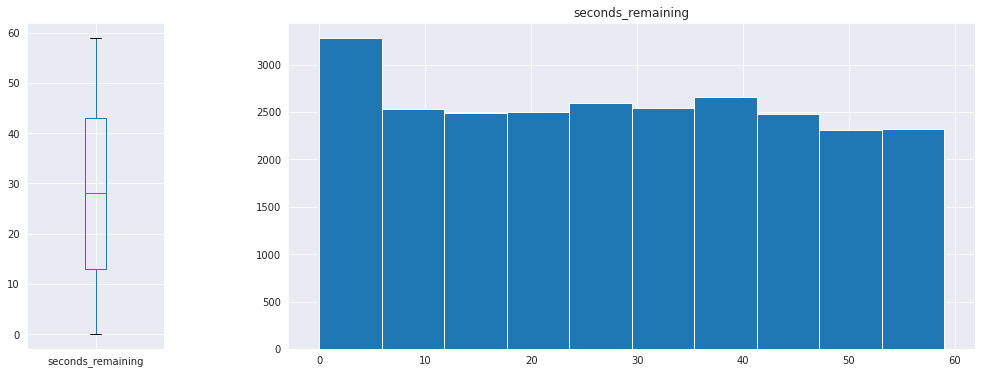

In [33]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='minutes_remaining',ax=axes[0]);
df.hist(column='minutes_remaining', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='seconds_remaining',ax=axes[0]);
df.hist(column='seconds_remaining', ax=axes[1]);

#### For Column: `period` & `playoffs`

In [34]:
print( df["period"].value_counts() )
print( df["playoffs"].value_counts() )

3    7002
1    6700
4    6043
2    5635
5     280
6      30
7       7
Name: period, dtype: int64
0    21939
1     3758
Name: playoffs, dtype: int64


#### For Column: `season`

In [35]:
df['season'].value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

#### For Column: `matchup`

In [36]:
df['matchup'].value_counts()

LAL @ SAS      853
LAL vs. SAS    765
LAL @ PHX      751
LAL @ SAC      751
LAL vs. HOU    722
              ... 
LAL @ PHO       29
LAL vs. NOP     21
LAL vs. SAN     20
LAL @ UTH       15
LAL vs. BKN     13
Name: matchup, Length: 74, dtype: int64

#### For Column: `shot_type`

In [37]:
# df[['shot_type', 'shot_zone_area','shot_zone_basic', 'shot_zone_range']]
df["shot_type"].value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

#### For Column: 'shot_zone_area'

In [38]:
df["shot_zone_area"].value_counts()

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64

#### For Column: `shot_zone_basic`

In [39]:
df["shot_zone_basic"].value_counts()

Mid-Range                10532
Restricted Area           5932
Above the Break 3         4720
In The Paint (Non-RA)     3880
Right Corner 3             333
Left Corner 3              240
Backcourt                   60
Name: shot_zone_basic, dtype: int64

#### For Column: `shot_zone_range`

In [40]:
df["shot_zone_range"].value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

#### For Column: `combined_shot_type`

In [41]:
df["combined_shot_type"].value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

#### For Column: `action_type`

In [42]:
df["action_type"].value_counts()

Jump Shot                          15836
Layup Shot                          2154
Driving Layup Shot                  1628
Turnaround Jump Shot                 891
Fadeaway Jump Shot                   872
Running Jump Shot                    779
Pullup Jump shot                     402
Turnaround Fadeaway shot             366
Slam Dunk Shot                       334
Reverse Layup Shot                   333
Jump Bank Shot                       289
Driving Dunk Shot                    257
Dunk Shot                            217
Tip Shot                             151
Step Back Jump shot                  106
Alley Oop Dunk Shot                   95
Floating Jump shot                    93
Driving Reverse Layup Shot            83
Hook Shot                             73
Driving Finger Roll Shot              68
Alley Oop Layup shot                  67
Reverse Dunk Shot                     61
Driving Finger Roll Layup Shot        59
Turnaround Bank shot                  58
Running Layup Sh

#### For Column: `opponent`

In [43]:
df["opponent"].value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

#### For Column: `game_date`
It is a datetime type and we have already removed all the `nan`s & `None`s from the dataset so there is nothing to for this.

#### For Column: `shot_made_flag`
Since it is a binary value column and also our `target` (for the dataset). We are simply going to analyse its distribution and see if it is a balanced dataset or not.

### Dataset distribution
Check whether we have a balanced dataset (almost equal number of positive and negative classes) or an imbalanced one. In this case we check distribution of the target label: **shot_made_flag**

In [44]:
df['shot_made_flag'].value_counts(normalize = True)

0.0    0.553839
1.0    0.446161
Name: shot_made_flag, dtype: float64

In [45]:
print(f"Shape of the df: {df.shape}")
df.head()

Shape of the df: (25697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


***
## Section 5: Domain Specific Analysis on the data

### Some basic feature engineering
Although we will perform this formally in the next notebook, we need this here to run one of our analysis.

In [10]:
def time_feature(df):
    df['time_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining']
    df.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)
    return df

From the maximum values of seconds and minutes we observe that it shows at what moment the shot was taken. Unfortunatelly we don't have information in which quarter the shot is taken.
Games in the NBA have a 12 quareter length. We can merge these two columns as time_remaining.
We will transfer the minutes left in seconds

**It will be useful to see the shots taken in the last seconds of the quareter in order to see how 'clutch' Kobe was**
Unfortunately we don't have data for the 24 second shot-clock.

In [11]:
def change_matchup(df):
    df['matchup'] = df['matchup'].apply(lambda x: str('away') if '@' in x else str('home'))
    return df

In [12]:
def basic_feature_engineering(df):
    """
    Perform initial feature engineering and data cleanup.
    The returned dataframe will be used for some initial data analytics
    :param df: input dataframe
    :return: copy of the input dataframe with all the modifications
    """
    df_new = df.copy(deep=True)
    df_new = change_matchup(df_new)
    df_new = time_feature(df_new)
    return df_new


In [13]:
df = basic_feature_engineering(df)

In [14]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,time_remaining
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,1,0,2000-01,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,away,POR,2,622
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,1,0,2000-01,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,away,POR,3,465
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,1,0,2000-01,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,away,POR,4,412
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,2,0,2000-01,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,away,POR,5,379
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,3,0,2000-01,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,away,POR,6,572


***
### Shot Analysis

We have few comments that we'd like to make and then show the analysis. 

**Note:** that there is only a 3PT and 2PT shot type. There is no Free Throw.

Every player has its sweet spot where he shoots better. Some players are better three point shooters, some shoot better from mid-range, some from the corner. It will be important to analyze the efficiency on every location.

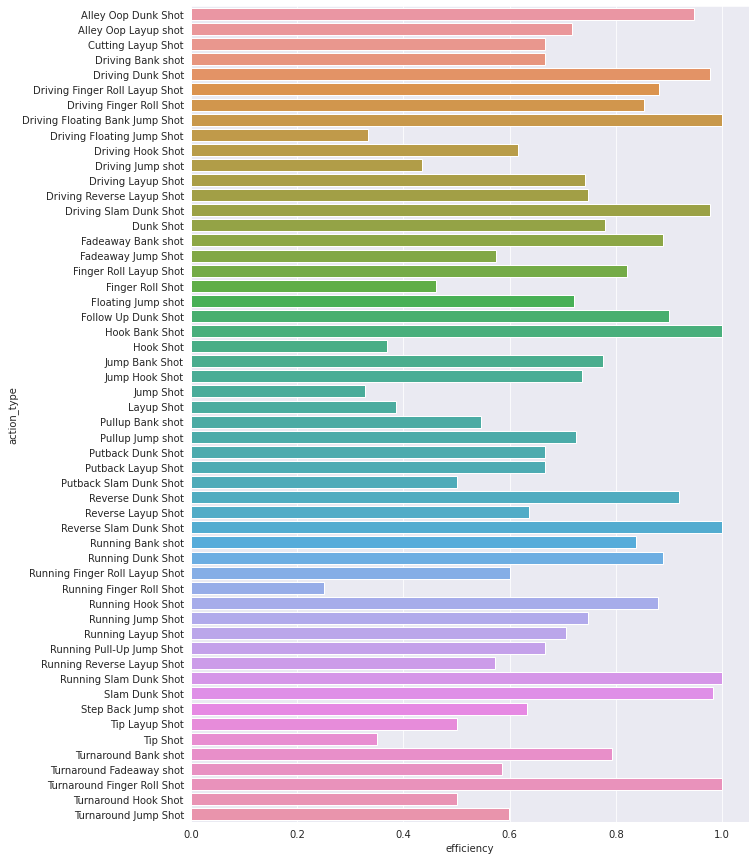

In [15]:
shots = df.groupby(['action_type'])['shot_made_flag'].value_counts(normalize=True).reset_index(name="efficiency")
shots_cleaned = shots[shots['shot_made_flag'] == 1.0][['action_type', 'efficiency']]
plt.figure(figsize=(10,15))
# todo order
ax = sns.barplot(data=shots_cleaned, x='efficiency', y='action_type', orient='h')

Action type (`action_type`) is the type of shot that led to shoot. We see that we mostly have Jump Shots and Layups.

We see that there is a very high shot efficiency when the player is dunking the ball in any type of action

# Questions we want to answer
How does the shooting efficiency change:
- during every season.
- by time left
- by distance or shot position
- by minutes remaining in each quarter.
- versus playing with different teams
- in the playoffs

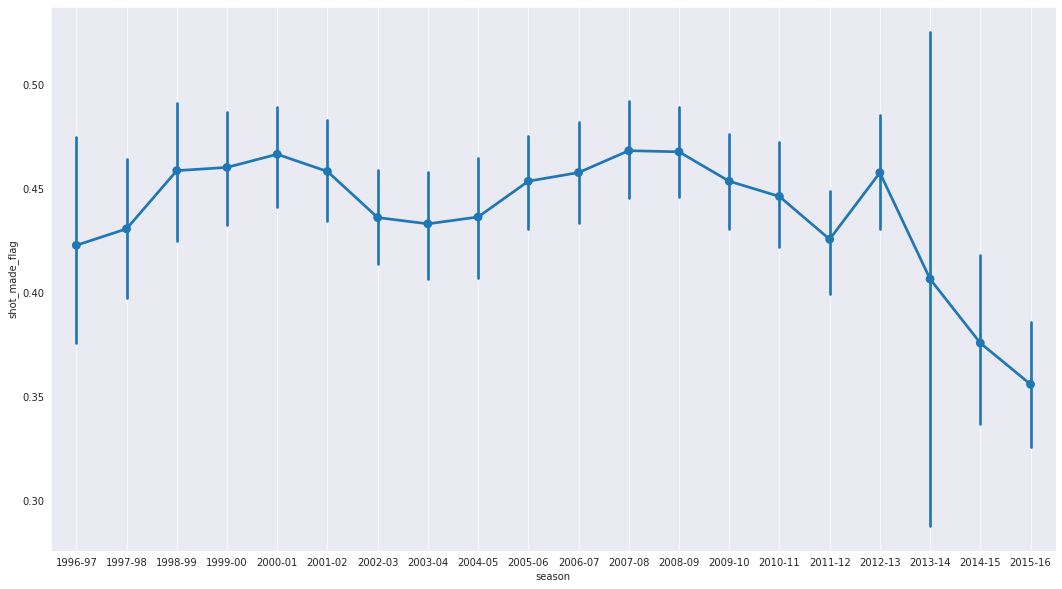

In [16]:
plt.figure(figsize=(18, 10))
ax = sns.pointplot(x='season', y='shot_made_flag', data=df, order=sorted(list(df['season'].unique())))
ax.grid()

#### Shooting playoff vs regular season
We notice that in most cases the shooting decreases in playoff

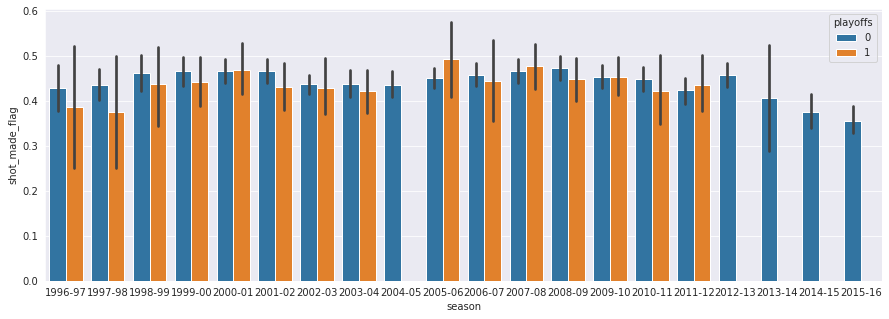

In [17]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='season', y='shot_made_flag', hue='playoffs',data=df, order=sorted(list(df['season'].unique())))

#### Shot efficiency by time left
for each period get the shot efficiency by time
We see that as the remaining time decreases, the shot efficiency is decreasing.

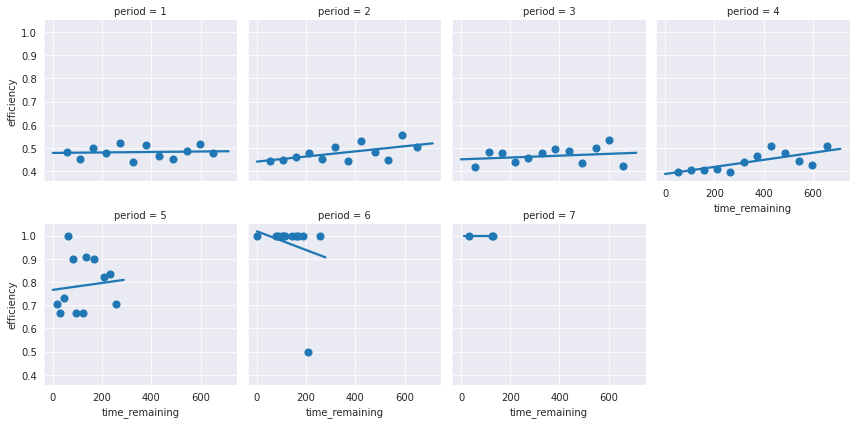

In [18]:
shot_period = df.groupby(['period', 'time_remaining'])['shot_made_flag'].value_counts(normalize=True).reset_index(name="efficiency")
shot_period = shot_period[shot_period['shot_made_flag'] == 1.0][['period', 'time_remaining', 'efficiency']]

g = sns.FacetGrid(shot_period, col="period", col_wrap=4)
g.map(sns.regplot,'time_remaining', 'efficiency', data=shot_period, x_bins=12, ci=None)

#### Versus teams
Variance is high for teams like BKN and VAN as they are new/old franchises.

<AxesSubplot:xlabel='opponent', ylabel='shot_made_flag'>

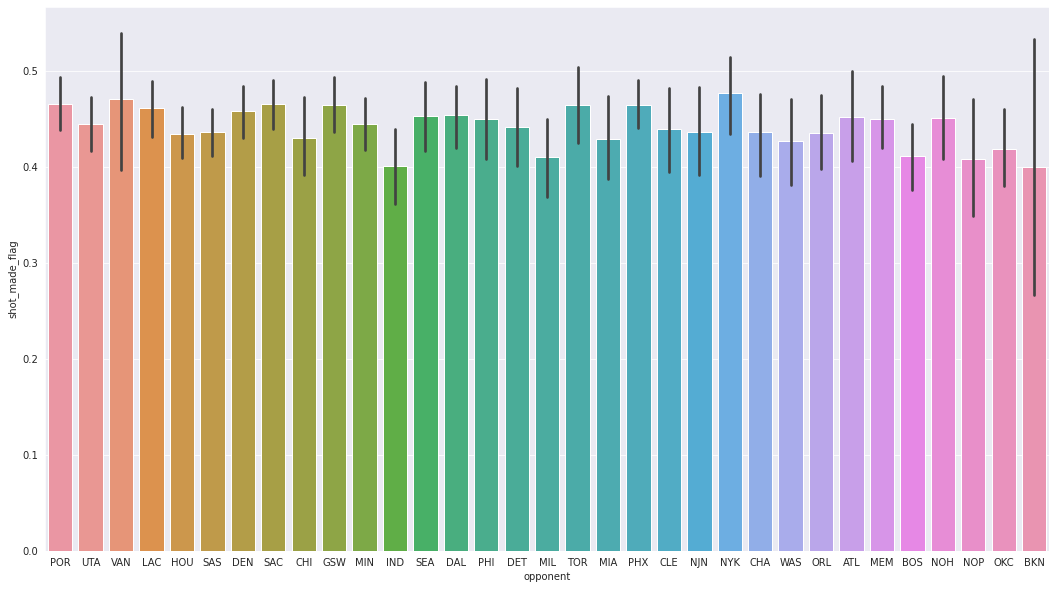

In [19]:
plt.figure(figsize=(18, 10))
sns.barplot(x='opponent', y='shot_made_flag', data=df)

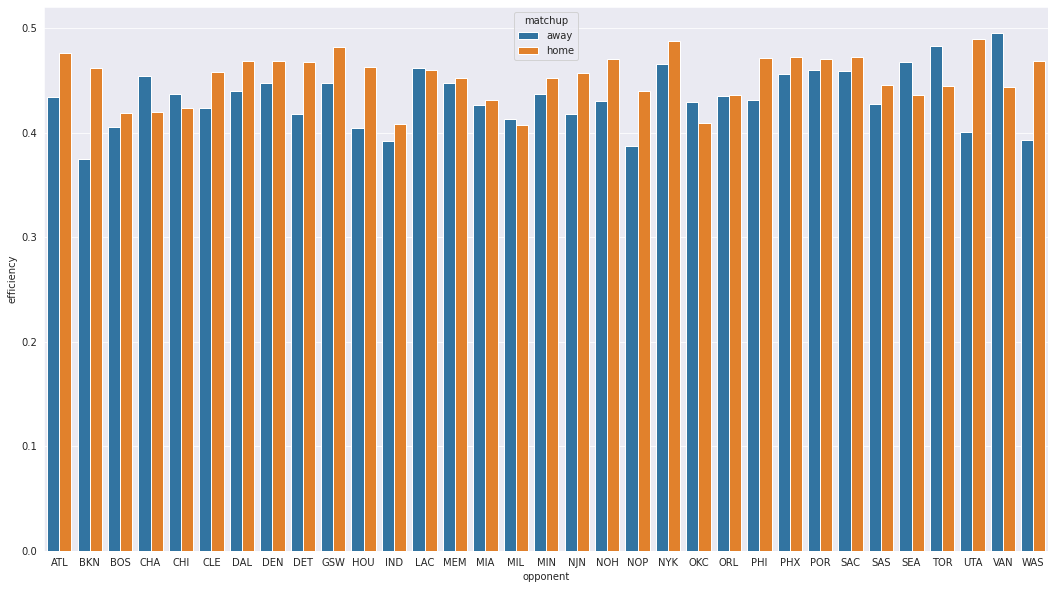

In [20]:
shot_team_home = df.groupby(['opponent', 'matchup'])['shot_made_flag'].value_counts(normalize=True).reset_index(name='efficiency')
shot_team_home = shot_team_home[shot_team_home['shot_made_flag'] == 1.0][['opponent', 'matchup', 'efficiency']]

plt.figure(figsize=(18, 10))
sns.barplot(x='opponent', y='efficiency', hue='matchup', data=shot_team_home)
del shot_team_home

/home/filip/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


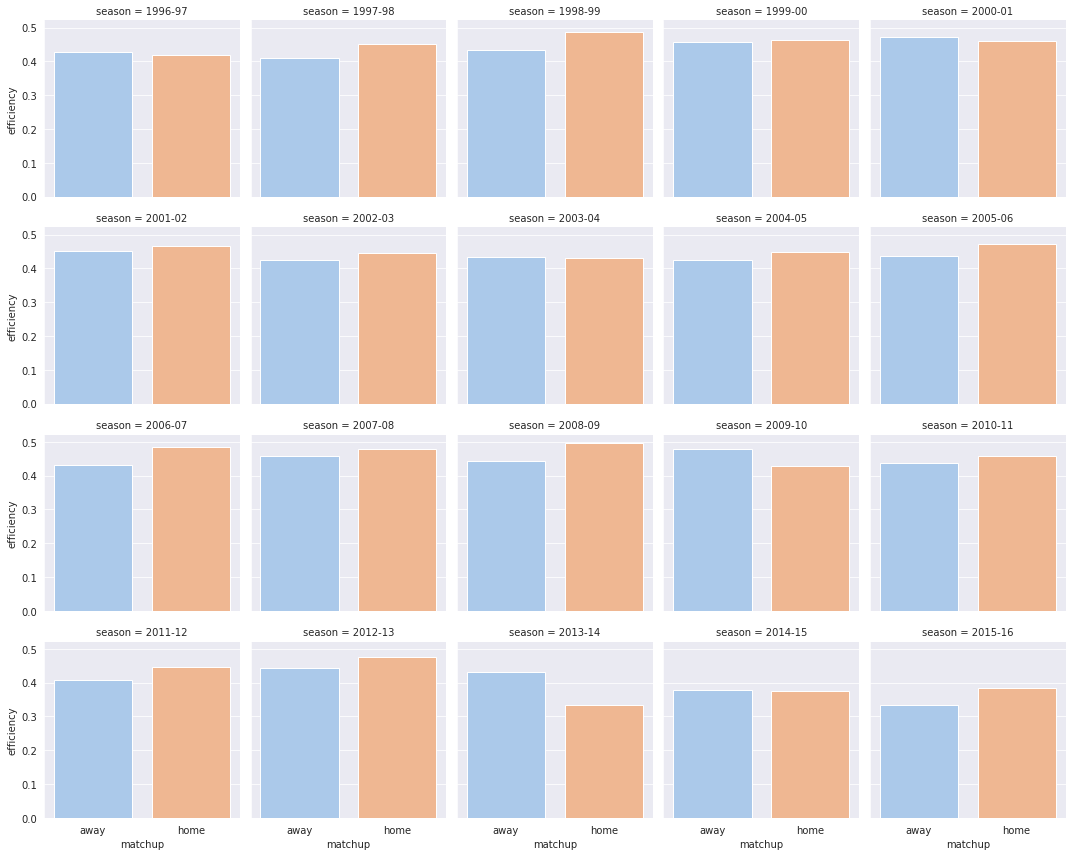

In [21]:
shot_team_home = df.groupby(['season', 'matchup'])['shot_made_flag'].value_counts(normalize=True).reset_index(name='efficiency')
shot_team_home = shot_team_home[shot_team_home['shot_made_flag'] == 1.0][['season', 'matchup', 'efficiency']]

g = sns.FacetGrid(shot_team_home, col="season", col_wrap=5)
g.map(sns.barplot,'matchup', 'efficiency', data=shot_team_home, palette='pastel')

(0.4, 0.5)

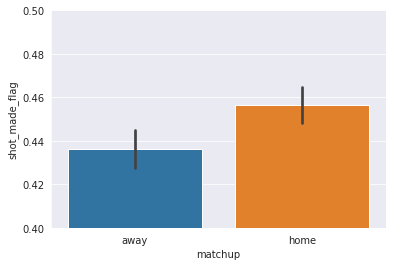

In [22]:
sns.barplot(x='matchup', y='shot_made_flag', data=df )
plt.ylim(0.4, 0.5)

#### Three point vs two point

<AxesSubplot:xlabel='season', ylabel='efficiency'>

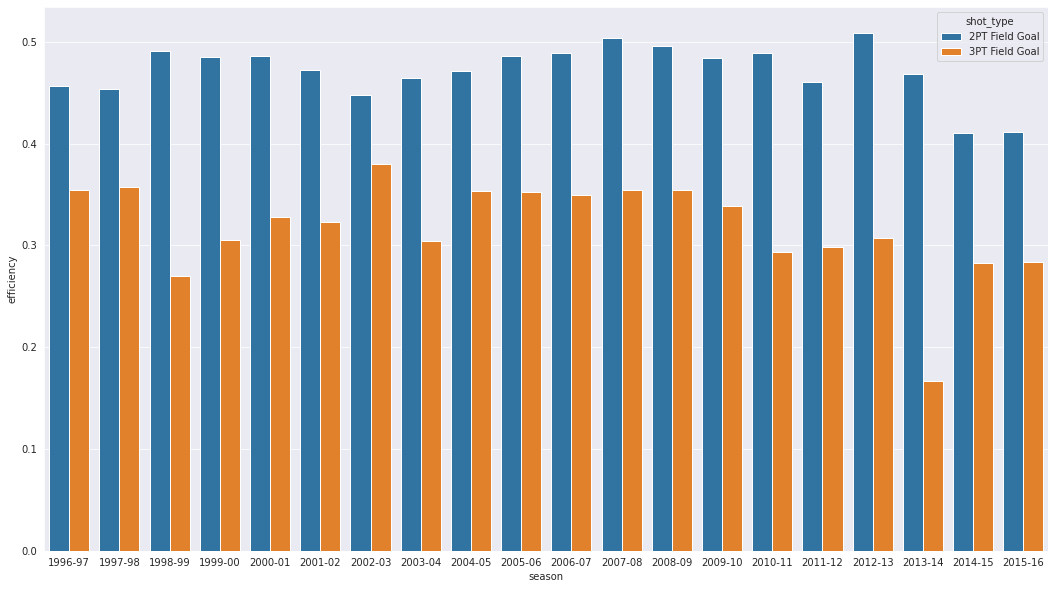

In [23]:
plt.figure(figsize=(18, 10))

shot_23 = df.groupby(['season', 'shot_type'])['shot_made_flag'].value_counts(normalize=True).reset_index(name='efficiency')
shot_23 = shot_23[shot_23['shot_made_flag'] == 1.0][['season', 'shot_type', 'efficiency']]
sns.barplot(data=shot_23, x='season', y='efficiency', hue='shot_type')

***
### Shot zoness

<AxesSubplot:xlabel='loc_x', ylabel='loc_y'>

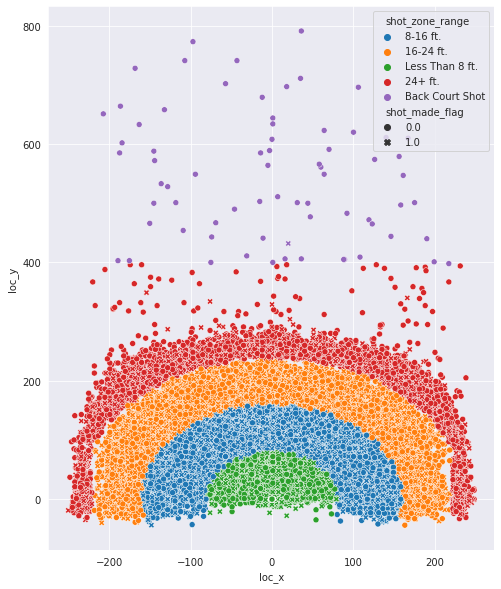

In [24]:
plt.figure(figsize=(8, 10))

sns.scatterplot(data=df, x='loc_x', y='loc_y', hue='shot_zone_range', style='shot_made_flag')

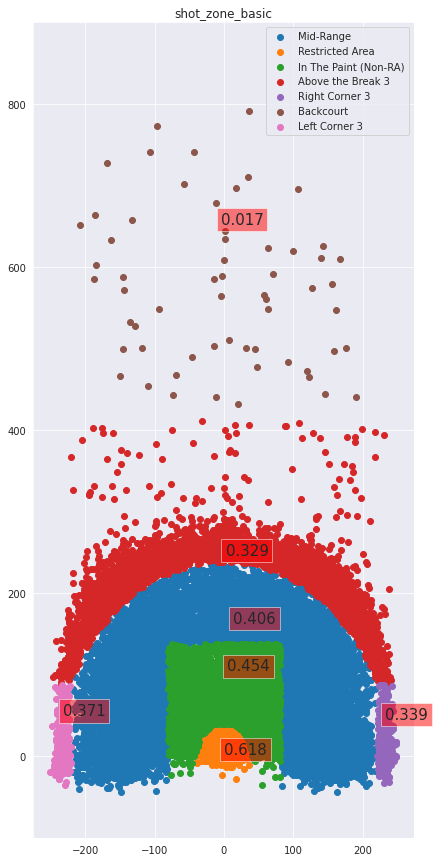

In [25]:
def plot_zone_wise(zone_name):
    c_mean = df.groupby(zone_name)['shot_made_flag'].mean()
    plt.figure(figsize=(15,15))
    for i, area in enumerate(df[zone_name].unique()):
        plt.subplot(121)
        c = df.loc[(df[zone_name]==area)]
        plt.scatter(c.loc_x, c.loc_y,alpha=1)
        plt.text(c.loc_x.mean(), c.loc_y.quantile(0.80), '%0.3f'%(c_mean[area]),size=15, bbox=dict(facecolor='red', alpha=0.5))
        plt.ylim(-100, 900)
    plt.legend(df[zone_name].unique())
    plt.title(zone_name)
    plt.show()
plot_zone_wise('shot_zone_basic')

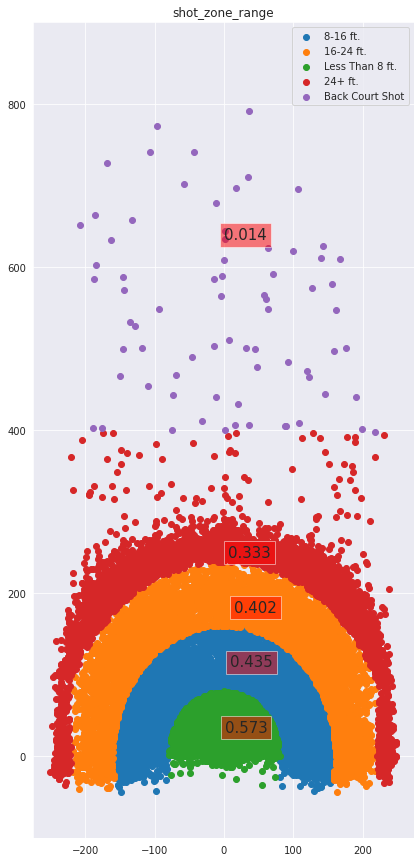

In [26]:
plot_zone_wise('shot_zone_range')

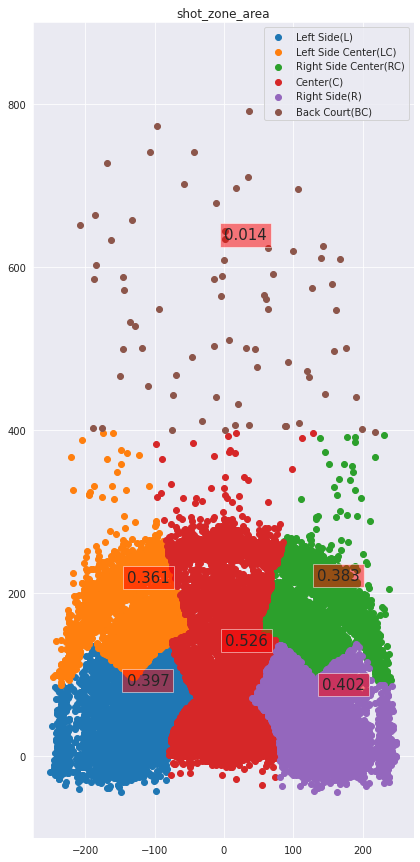

In [27]:
plot_zone_wise('shot_zone_area')

<AxesSubplot:xlabel='shot_distance'>

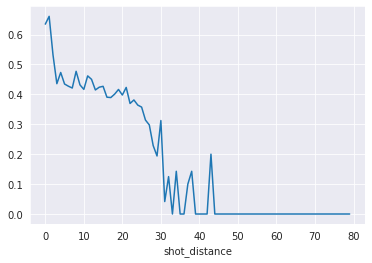

In [28]:
df.groupby('shot_distance')['shot_made_flag'].mean().plot(kind='line')

In [29]:
df.to_csv('../data/data1.csv', index=False)